In [137]:
import argparse
import sys
import os.path

import torch
import torch.nn as nn
import numpy as np

import h5py as h5
import SimpleITK as sitk
from PIL import Image
import torchvision.transforms.functional as TF
import SimpleITK as sitk

In [138]:
cur_path = os.path.abspath(".")
data_path = os.path.join(cur_path, 'data')
print(f"cur_path:{cur_path}")
print(f"data_path:{data_path}")

print('hello')

cur_path:f:\v3r\study\AI\reg2d3d\rg2-work
data_path:f:\v3r\study\AI\reg2d3d\rg2-work\data
hello


In [139]:
def resample_image(itk_image:sitk.Image,target_size =[1536,1536,1], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    min_spacing_id = original_size.index(min(original_size[:-1]))
    print(original_size)
    print(min_spacing_id)
    min_spacing = original_spacing[min_spacing_id]*original_size[min_spacing_id]/target_size[min_spacing_id]
    target_spacing = [min_spacing,min_spacing,1]
    print(f"spacing:{target_spacing}")

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(target_spacing)
    resample.SetSize(target_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    # resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkLinear)

    return resample.Execute(itk_image)

In [155]:

img = sitk.ReadImage(os.path.join(data_path, 'image_000.nii.gz'))
img = resample_image(img)



print(img.GetSize())
xray_data = sitk.GetArrayFromImage(img)

xray_data = xray_data.squeeze()

if not np.issubdtype(xray_data.dtype,np.float32) :
    xray_data = xray_data.astype(np.float32)

print(type(xray_data),xray_data.shape,xray_data.dtype)


(978, 1067, 1)
0
spacing:[0.0980546875, 0.0980546875, 1]
(1536, 1536, 1)
<class 'numpy.ndarray'> (1536, 1536) float32


<function matplotlib.pyplot.show(close=None, block=None)>

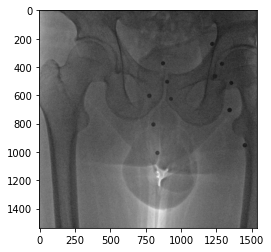

In [156]:
import matplotlib.pyplot as plt

plt.imshow(xray_data[:,:],cmap='gray')
plt.show


(1536, 1536)


<function matplotlib.pyplot.show(close=None, block=None)>

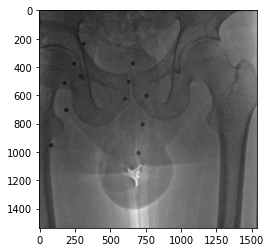

In [142]:
# xray_data = np.fliplr(xray_data)
# print(xray_data.shape)
# plt.imshow(xray_data[:,:],cmap='gray')
# plt.show



In [143]:
#model
from unet    import *
#python -u test_ensemble.py ipcai_2020_ds_8x.h5 spec_1_test.h5 --pats 1 --nets yy_best_net.pt
# os.path.pardir('')
torch_map_loc = None
network_paths=list()

network_paths.append(os.path.join(cur_path,'yy_best_net.pt'))  
print(network_paths)

cpu_dev = torch.device('cpu')
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_map_loc = dev
print(f"dev type:{dev}")

nets=[]
for net_path in network_paths:
        print('  loading state from disk for: {}'.format(net_path))
        
        state = torch.load(net_path, map_location=torch_map_loc)
        
        print('  loading unet params from checkpoint state dict...')
        num_classes         = state['num-classes']
        unet_num_lvls       = state['depth']
        unet_init_feats_exp = state['init-feats-exp']
        unet_batch_norm     = state['batch-norm']
        unet_padding        = state['padding']
        unet_no_max_pool    = state['no-max-pool']
        unet_use_res        = state['unet-use-res']
        unet_block_depth    = state['unet-block-depth']
        proj_unet_dim       = state['pad-img-size']
        batch_size          = state['batch-size']
        num_lands           = state['num-lands']
        epoch               = state['epoch']
        loss                = state['loss']
        best_valid_loss     = state['best-valid-loss']

        print('             num. classes: {}'.format(num_classes))
        print('                    depth: {}'.format(unet_num_lvls))
        print('        init. feats. exp.: {}'.format(unet_init_feats_exp))
        print('              batch norm.: {}'.format(unet_batch_norm))
        print('         unet do pad img.: {}'.format(unet_padding))
        print('              no max pool: {}'.format(unet_no_max_pool))
        print('    reflect pad img. dim.: {}'.format(proj_unet_dim))
        print('            unet use res.: {}'.format(unet_use_res))
        print('         unet block depth: {}'.format(unet_block_depth))
        print('               batch size: {}'.format(batch_size))
        print('              num. lands.: {}'.format(num_lands))
        
        print('          Last Epoch: {}'.format(epoch))
        print('           Last Loss: {}'.format(loss.item()))
        print('    Best Valid. Loss: {}'.format(best_valid_loss))

        print('    creating network')
        net = UNet(n_classes=num_classes, depth=unet_num_lvls, wf=unet_init_feats_exp, batch_norm=unet_batch_norm, padding=unet_padding, max_pool=not unet_no_max_pool,
                   num_lands=num_lands, do_res=unet_use_res, block_depth=unet_block_depth)
    
        net.load_state_dict(state['model-state-dict'])

        del state

        print('  moving network to device...')
        net.to(dev)
        
        nets.append(net)

['f:\\v3r\\study\\AI\\reg2d3d\\rg2-work\\yy_best_net.pt']
dev type:cuda:0
  loading state from disk for: f:\v3r\study\AI\reg2d3d\rg2-work\yy_best_net.pt
  loading unet params from checkpoint state dict...
             num. classes: 7
                    depth: 6
        init. feats. exp.: 5
              batch norm.: True
         unet do pad img.: True
              no max pool: True
    reflect pad img. dim.: 192
            unet use res.: True
         unet block depth: 2
               batch size: 5
              num. lands.: 14
          Last Epoch: 864
           Last Loss: -0.7125652432441711
    Best Valid. Loss: -0.8047299385070801
    creating network
  moving network to device...


In [144]:
#if __name__ == '__main__':
    

In [145]:
from util import *
def seg_single_data_ensemble(data,net,dev=None,num_lands=0):
    
  
    orig_img_shape = (180,180)

    # dst_ds = h5_f.create_dataset('nn-segs', (1, *orig_img_shape),
    #                              dtype='u1',
    #                              chunks=(1, *orig_img_shape),
    #                              compression="gzip", compression_opts=9)
    # if num_lands > 0:
    #     dst_heats_ds = h5_f.create_dataset('nn-heats', (1, num_lands, *orig_img_shape),
    #                                     chunks=(1,1,*orig_img_shape),
    #                                     compression="gzip", compression_opts=9)  
    with torch.no_grad():
        net.eval()
        input = data.to(dev)
        net_out = net(input)
        if (num_lands > 0) or (type(net_out) is tuple):
            pred_masks = net_out[0]
            pred_heats = net_out[1]  
        else:
            pred_masks = net_out
        
        print(f"pred_mask shape:{pred_masks.shape}")
        pred_masks = center_crop(pred_masks, orig_img_shape)

        if num_lands > 0:
            pred_heats = center_crop(pred_heats, orig_img_shape)
            
            pred_heats_min = pred_heats.min().item()
            pred_heats_max = pred_heats.max().item()
            
            pred_heats = (pred_heats - pred_heats_min) / (pred_heats_max - pred_heats_min)


        (_, pred_masks) = torch.max(pred_masks, dim=1) 

        # write to file
        dst_seg_ds = pred_masks.view(orig_img_shape).cpu().numpy()
        dst_heats_ds = pred_heats.cpu().numpy()
        print(f"dst_seg_ds:{dst_seg_ds.shape},{dst_seg_ds.dtype}\n dst_heart_ds:{dst_heats_ds.shape},{dst_heats_ds.dtype}")
        return dst_seg_ds, dst_heats_ds                   

In [146]:
#Log transform
def ogarithmic_transformation(input_image:np.ndarray, c=1, inplace = True):
    '''
    对数变换
    :param input_image: 原图像
    :param c: 对数变换超参数
    :return: 对数变换后的图像
    '''
    # input_image_np = np.copy(input_image)
    input_image_cp = input_image
    if not inplace:
        input_image_cp = input_image.copy()
        
    output_imgae = c * np.log(1 + input_image_cp) # 输出图像

    return output_imgae

In [147]:
def prepare_data(cur_proj_np:np.ndarray):
    
    #1.剪裁
    cur_proj_np = cur_proj_np[50:-50,50:-50]

    # 2.下采样
    # Since the projections are 1536x1536, a tiled image of ~100 projections
    # may be excessively large, downsample in this case
    #overlay_ds_factor = 1.0   # no downsampling
    overlay_ds_factor = 0.125 # downsample 8x in each 2D dim

    need_to_ds_overlay = abs(overlay_ds_factor - 1.0) > 0.001

    (proj_num_cols,proj_num_rows) = cur_proj_np.shape

    # downsampled overlay dimensions
    ds_proj_num_cols = int(round(proj_num_cols * overlay_ds_factor)) if need_to_ds_overlay else proj_num_cols
    ds_proj_num_rows = int(round(proj_num_rows * overlay_ds_factor)) if need_to_ds_overlay else proj_num_rows

    pil = TF.to_pil_image(cur_proj_np)
    if need_to_ds_overlay:
        pil = pil.resize((ds_proj_num_cols, ds_proj_num_rows), Image.BILINEAR)
        # cur_proj = TF.to_tensor(pil)
        # print(f"cur_proj shape:{cur_proj.shape}")
    # else:
    cur_proj_np = np.array(pil)
    print(f"cur dtype:{cur_proj_np.dtype}")
    # #show
    # plt.imshow(pil,cmap='gray')
    # plt.show()
    
    #3.log transform
    cur_proj_np = ogarithmic_transformation(cur_proj_np,1)
    #cur_proj = torch.log(1+cur_proj)

    #4.pading 到192x192
    cur_proj = torch.from_numpy(np.pad(cur_proj_np,
                                 ( (6,6), (6,6)),
                                 'reflect'))
    # cur_proj = TF.pad(cur_proj,(0,6,6),0,'reflect')
    cur_proj = (cur_proj - cur_proj.mean()) / cur_proj.std()

    x = torch.unsqueeze(cur_proj,0)
    x = torch.unsqueeze(x,0).type(torch.FloatTensor)  # 转Float
    print(f"cur_proj shape:{x.shape}\n cur_proj dtype:{x.dtype}")


    return x

In [148]:

# src_data_file_path = os.path.join(data_path, 'ipcai_2020_ds_8x.h5')
# dst_data_file_path = os.path.join(data_path, 'spec_301_resample.h5')

test_pats =[]
test_pats.append(1)

land_names = ['FH-l',   'FH-r',
              'GSN-l',  'GSN-r',
              'IOF-l',  'IOF-r',
              'MOF-l',  'MOF-r',
              'SPS-l',  'SPS-r',
              'IPS-l',  'IPS-r',
              'ASIS-l', 'ASIS-r']

print('initializing testing data')
xray_data = prepare_data(xray_data) 


initializing testing data
cur dtype:float32
cur_proj shape:torch.Size([1, 1, 192, 192])
 cur_proj dtype:torch.float32


In [149]:
# print('Length of testing dataset: {}'.format(len(test_ds)))

print('running network on projections')
# seg_dataset_ensemble(test_ds, nets, f, dev=dev, num_lands=num_lands, times=times)

infer_seg,infer_heatmap = seg_single_data_ensemble(xray_data,nets[0],dev=dev,num_lands=num_lands)

print('get segment and heatmap...')

running network on projections
pred_mask shape:torch.Size([1, 7, 192, 192])
dst_seg_ds:(180, 180),int64
 dst_heart_ds:(1, 14, 180, 180),float32
get segment and heatmap...


In [150]:
# MIT License
#
# Copyright (c) 2020 Robert Grupp
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# This program extracts anatomical landmark locations, for a single projection,
# that were inferred by a neural network and saved in CSV format.
# See https://github.com/rg2/DeepFluoroLabeling-IPCAI2020/tree/master/train_test_code
# The output file format is FCSV, which is a 3D Slicer and xReg compatible file format.
# This allows the estimated landmarks to be used for the intraoperative registration strategy.
# A downsampling factor needs to be passed which matches the amount of downsampling applied 
# to the full-resolution projections to create training data. (e.g. 0.125 for 8x downsampling).

import sys
import csv
import os.path

def write_lands_map_to_fcsv(lands, dst_fcsv_path, lps_to_ras=True):
    with open(dst_fcsv_path, 'w') as f:
        f.write('# Markups fiducial file version = 4.6\n')
        f.write('# CoordinateSystem = 0\n')
        f.write('# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID\n')

        for (land_name, land_pt) in lands.items():
            x = land_pt[0]
            y = land_pt[1]
            z = land_pt[2]

            if lps_to_ras:
                x *= -1
                y *= -1

            f.write(',{:.8f},{:.8f},{:.8f},0,0,0,1,1,1,0,{},,\n'.format(x,y,z,land_name))

        f.flush()

def extract_lands_map_for_proj_from_nn_csv(src_nn_csv_path, pat_idx, proj_idx, ds_factor):
    kLAND_NAMES = [ 'FH-l',   'FH-r',
                    'GSN-l',  'GSN-r',
                    'IOF-l',  'IOF-r',
                    'MOF-l',  'MOF-r',
                    'SPS-l',  'SPS-r',
                    'IPS-l',  'IPS-r',
                    'ASIS-l', 'ASIS-r']


    kCROP_WIDTH_FULL_RES_PIX = 50
    kCROP_HIGH_FULL_RES_PIX = 50
    kORIG_PIX_SPACING = 0.098



    lands_map = { }

    with open(src_nn_csv_path) as f:
        csv_reader = csv.DictReader(f)
        
        for csv_row in csv_reader:
            if (int(csv_row['pat']) == pat_idx) and (int(csv_row['proj']) == proj_idx):
                r = int(csv_row['row'])
                c = int(csv_row['col'])

                if (r >= 0) and (c >= 0):
                    # y = ((r / ds_factor) + kCROP_WIDTH_FULL_RES_PIX) * kORIG_PIX_SPACING
                    # x = ((c / ds_factor) + kCROP_WIDTH_FULL_RES_PIX) * kORIG_PIX_SPACING

                    # 看着不太对
                    # y = ((r / ds_factor) + kCROP_WIDTH_FULL_RES_PIX) * kORIG_PIX_SPACING
                    # x = ((c / ds_factor) + kCROP_HIGH_FULL_RES_PIX) * kORIG_PIX_SPACING

                    y = ((r / ds_factor) + kCROP_HIGH_FULL_RES_PIX) * kORIG_PIX_SPACING
                    x = ((c / ds_factor) + kCROP_WIDTH_FULL_RES_PIX) * kORIG_PIX_SPACING


                    lands_map[kLAND_NAMES[int(csv_row['land'])]] = (x,y,0.0)

    return lands_map


python est_lands_csv.py data/spec_301_resample.h5  nn-heats --use-seg nn-segs --pat 1 --out spec_resample_301_lands_930.csv

In [151]:
# Estimate landmark point locations using already estimated heatmaps
#
# Copyright (C) 2019-2020 Robert Grupp (grupp@jhu.edu)
#
# You should have received a copy of the GNU General Public License
# along with this program. If not, see <https://www.gnu.org/licenses/>.

import argparse
import sys
import math
import time

import numpy as np

import torch

import h5py as h5

from dataset import *
from util import *

from ncc import ncc_2d



#python est_lands_csv.py data/spec_301_resample.h5  nn-heats --use-seg nn-segs --pat 1 --out spec_resample_301_lands_930.csv

# heat_file_path = "data/spec_301_resample.h5"
heats_group_path = 'nn-heats'

out_csv_path = "spec_resample_301_lands_930.csv"

pat_ind =  1

no_csv_hdr =  None

seg_ds_path = 'nn-segs'

# land_names = get_land_names_from_dataset(heat_file_path)

num_lands = len(land_names)

seg_labels_to_use_for_lands = { 'FH-l'   : 5,
                                'FH-r'   : 6,
                                'GSN-l'  : 1,
                                'GSN-r'  : 2,
                                'IOF-l'  : 1,
                                'IOF-r'  : 2,
                                'MOF-l'  : 1,
                                'MOF-r'  : 2,
                                'SPS-l'  : 1,
                                'SPS-r'  : 2,
                                'IPS-l'  : 1,
                                'IPS-r'  : 2,
                                'ASIS-l' : 1,
                                'ASIS-r' : 2,
                                'PSIS-l' : 1,
                                'PSIS-r' : 2,
                                'PIIS-l' : 1,
                                'PIIS-r' : 2 }

csv_out = open(out_csv_path, 'w')
if not no_csv_hdr:
    csv_out.write('pat,proj,land,row,col,time\n')

print('reading heatmaps...')
# f = h5.File(heat_file_path, 'r')
if infer_heatmap is not None:
    heats = torch.from_numpy(infer_heatmap)
    # heats = torch.unsqueeze(heats,0)
segs = None
if infer_seg is not None :
    segs = torch.from_numpy(infer_seg)
    segs = torch.unsqueeze(segs,0)
# f.close()
print(f'heats shape:{heats.shape},{type(heats)}\n heats shape:{segs.shape},{type(segs)}')
landmark_local_template = get_gaussian_2d_heatmap(25, 25, 2.5)

print('detecting landmark locations...')
for i in range(heats.shape[0]):
    for land_ind in range(num_lands):
        seg_label_to_use = seg_labels_to_use_for_lands[land_names[land_ind]]

        start_time = time.time()

        cur_heat = heats[i,land_ind,:,:]
        
        cur_heat_pad = torch.from_numpy(np.pad(cur_heat.cpu().numpy(), ((12, 12), (12, 12)), 'reflect'))

        print(f"cur_heat_pad shape:{cur_heat_pad.shape}")

        def rule_3():
            max_ind = None

            if (segs is None) or (seg_label_to_use is None):
                max_ind = np.unravel_index(torch.argmax(cur_heat).item(), cur_heat.shape)
            else:
                tmp_heat = cur_heat.clone().detach()
                tmp_heat[segs[i,:,:] != seg_label_to_use] = -math.inf#浮点负无穷大

                #获取最大值对应的坐标 
                max_ind = np.unravel_index(torch.argmax(tmp_heat).item(), cur_heat.shape)
                if tmp_heat[max_ind[0], max_ind[1]] == -math.inf:
                    max_ind = None
            
            if max_ind is not None:
                # Since this index was first computed in the un-padded image, we do not need to subtract
                # the padding amount to get the start location in the padded image (it implicitly has -12)
                start_roi_row = max_ind[0]
                start_roi_col = max_ind[1]
                print(f"start_roi_row:{start_roi_row} start_roi_col:{start_roi_col}")

                heat_roi = cur_heat_pad[start_roi_row:(start_roi_row+25), start_roi_col:(start_roi_col+25)]
                
                if ncc_2d(landmark_local_template, heat_roi) < 0.9:
                    max_ind = None
            
            return max_ind

        max_ind = rule_3()
        if max_ind is None:
            # use -1 to indicate landmark not found
            max_ind = [-1, -1]
        
        stop_time = time.time()

        csv_line = '{},{},{},{},{},{:3f}'.format(pat_ind, i, land_ind, max_ind[0], max_ind[1], stop_time - start_time)
        csv_out.write('{}\n'.format(csv_line))

csv_out.flush()
csv_out.close()


reading heatmaps...
heats shape:torch.Size([1, 14, 180, 180]),<class 'torch.Tensor'>
 heats shape:torch.Size([1, 180, 180]),<class 'torch.Tensor'>
detecting landmark locations...
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:39 start_roi_col:139
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:45 start_roi_col:8
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:69 start_roi_col:77
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:9 start_roi_col:25
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:72 start_roi_col:106
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:77 start_roi_col:43
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:65 start_roi_col:97
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:67 start_roi_col:55
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:61 start_roi_col:76
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:61 start_roi_col:71
cur_heat_pad shape:torch.Size([204, 204])
start_roi_row:73 st

In [152]:

src_nn_csv_path = "spec_resample_301_lands_930.csv"
ds_factor = float(0.125)
dst_fcsv_path = "proj_301_resample_lands.fcsv"

pat_idx = 1
proj_idx = 0

write_lands_map_to_fcsv(
    extract_lands_map_for_proj_from_nn_csv(src_nn_csv_path, pat_idx,
                                            proj_idx, ds_factor),
    dst_fcsv_path)


In [121]:
x = torch.tensor([[1]])